# 1.Imports
To set up the conda environment with pytorch type these into the terminal:

conda create -n torch_env python=3.12

source activate torch_env

pip install ipykernel

python -m ipykernel install --user --name=torch_env

conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

pip install nibabel pynrrd numpy matplotlib tqdm scikit-learn imgaug


In [1]:
import os
import re
import shutil
import gzip
import nibabel as nib
import nrrd

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from skimage.metrics import hausdorff_distance
from skimage.measure import label   
from skimage.transform import resize   

import imgaug.augmenters as iaa

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA A40'

In [3]:
train = True # Should the model be trained or should only be the model loaded and inferred
learning_rate = 0.001
max_num_epochs = 20 # Maximum number of epochs. Early stopping can cause that this is not reached.
early_stopping_patience = 4 # How many times in a row the validation loss is higher than the lowest recorded one without stopping training
batch_size = 16

# 2. Data Splitting
Rather than splitting the images, patients are splitted. This is because each patient is contained with multiple images. If some of these images from one patient end up in the training set and some in the test set, the model has already overfitted the physiology of that specific patient and test results are worse than on truly unseen data.

In [4]:
patients = np.arange(1,101,1)
labels = [int((i - 1) / (100/5)) for i in patients] # List where first 20 entries are 0, next 20 entries are 1 etc.
assert labels.count(0) == 20 and labels.count(4) == 20
X_train, X_val, y_train, y_val = train_test_split(patients, labels, test_size=0.1, stratify=labels, random_state=1) # It stratifies over the labels given

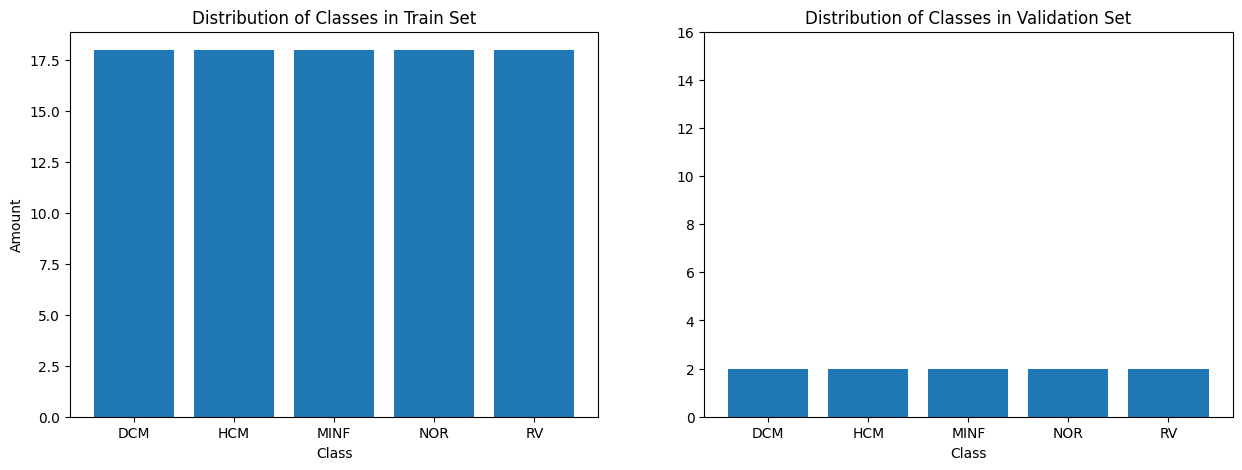

In [5]:
# Verify stratification worked and show sizes of the sets
fig, axs = plt.subplots(1, 2, figsize=(15,5))
classes = ["DCM","HCM","MINF", "NOR", "RV"]
axs[0].bar(classes, [y_train.count(i) for i in [0,1,2,3,4]])
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Amount")
axs[0].set_title("Distribution of Classes in Train Set")

axs[1].bar(classes, [y_val.count(i) for i in [0,1,2,3,4]])
axs[1].set_xlabel("Class")
axs[1].set_ylim(0,16)
axs[1].set_title("Distribution of Classes in Validation Set")
plt.show()

In [6]:
# Now save actual image_paths in the sets instead of patient ids
all_imgs = os.listdir('all')
all_imgs.sort()
all_imgs = all_imgs[::2] # Every second one is an image and every other a mask
train_X = []
val_X = []
for img_path in all_imgs:
    patient_id = int(re.search(r"patient(\d+)__", img_path).group(1)) # Get id of patient from filename
    if patient_id in X_train: # If the patient id of the current image path is in the train set, the image gets also added to the train set
        train_X.append(img_path)
    if patient_id in X_val:
        val_X.append(img_path)

## Defining Custom Dataset
It allows for easier management of how the images and masks are loaded and given to the model.
Only image paths have to be provided, it also gets the masks from that.
Make the masks only keep one class vor the left ventricle.
And augment images when the model needs an image. Every epoch each image is therefore augmented differently.

In [7]:
class CustomDataset(Dataset):
    def __init__(self, filenames):
        self.filenames = filenames

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]

        # Load your data here, assuming it's an image for example
        image, _ = nrrd.read('all/'+filename)
        mask, _ = nrrd.read('all/'+filename.replace("img","msk")) # Load corresponding mask
        pid = int(re.search(r"patient(\d+)__", filename).group(1)) # Get pid of current patient
        mask[(mask==1) | (mask==2)] = 0 # Set other classes to 0
        mask[mask==3] = 255 # Make pixels for the LV class white
        image = resize(image, (300,300))
        lower_clip, upper_clip = np.percentile(image,[2,98])
        image[image>upper_clip] = upper_clip
        image[image<lower_clip] = lower_clip
        image = ((image - image.min()) / (image.max() - image.min())) * 255 # MinMax normalization
        mask = resize(mask, (300,300))
        return image, mask, pid


# 3. Image Augmentation
For this only augmentations from the pytorch framework are used as these are the most significant augmentations and the training time for 20 epochs already approaches the half hour mark

In [8]:
seq_train = iaa.Sequential([
    iaa.AverageBlur(k=(4, 5)), # blur image using local means with kernel sizes between 4 and 5
    iaa.Sometimes(0.2,[iaa.GaussianBlur((0, 3.0))]), # blur images with a sigma between 0 and 3.0
    
    iaa.Sometimes(0.2,[iaa.MedianBlur(k=(3, 11))]), # blur image using local medians with kernel sizes between 3 and 11

    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images,
    iaa.Dropout((0.01, 0.1)), # randomly remove up to 10% of the pixels
    
    iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
    iaa.Sometimes(0.5,iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
    iaa.Flipud(0.5),
    iaa.Sometimes(0.5, iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
        rotate=(-180, 180), # rotate by -45 to +45 degrees
        shear=(-16, 16), # shear by -16 to +16 degrees
    )),
    iaa.CropToFixedSize(width=256, height=256), # Crop after all other transforms to reduce missing values at the edges
])
seq_eval = iaa.Sequential([
    iaa.Resize((256, 256)),
])

In [9]:
# Create Dataset objects and apply transformations to them. Data will be provided in batches to the trainer by the DataLoader.
generator = torch.Generator().manual_seed(1)
def collate_fn_train(batch):
    images, masks, pids = zip(*batch)
    images, masks, pids = np.stack(images).astype(np.uint8), np.expand_dims(np.stack(masks).astype(np.uint8),3), np.stack(pids)
    
        
    images, masks = seq_train(images=images, segmentation_maps=masks)
    images = np.expand_dims(images,1).astype("float32")
    images = (images - images.min())/ (images.max() - images.min()) # Final normalization
    return torch.tensor(images), torch.tensor(np.moveaxis(masks,3,1).astype("float32")), pids
def collate_fn_test(batch):
    images, masks, pids = zip(*batch)
    images, masks, pids = np.stack(images), np.expand_dims(np.stack(masks).astype(np.uint8),3), np.stack(pids)
    images, masks = seq_eval(images=images, segmentation_maps=masks)
    images = np.expand_dims(images,1).astype("float32")
    images = (images - images.min())/ (images.max() - images.min())
    return torch.tensor(images), torch.tensor(np.moveaxis(masks,3,1).astype("float32")), pids

train_set = CustomDataset(train_X)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, generator=generator, collate_fn=collate_fn_train,  prefetch_factor=32, num_workers=16) # create more workers that prefetch batches into the RAM. GPU is not fully utilized otherwise
val_set = CustomDataset(val_X)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, generator=generator, collate_fn=collate_fn_test,  prefetch_factor=32, num_workers=16)

### Plotting augmented images

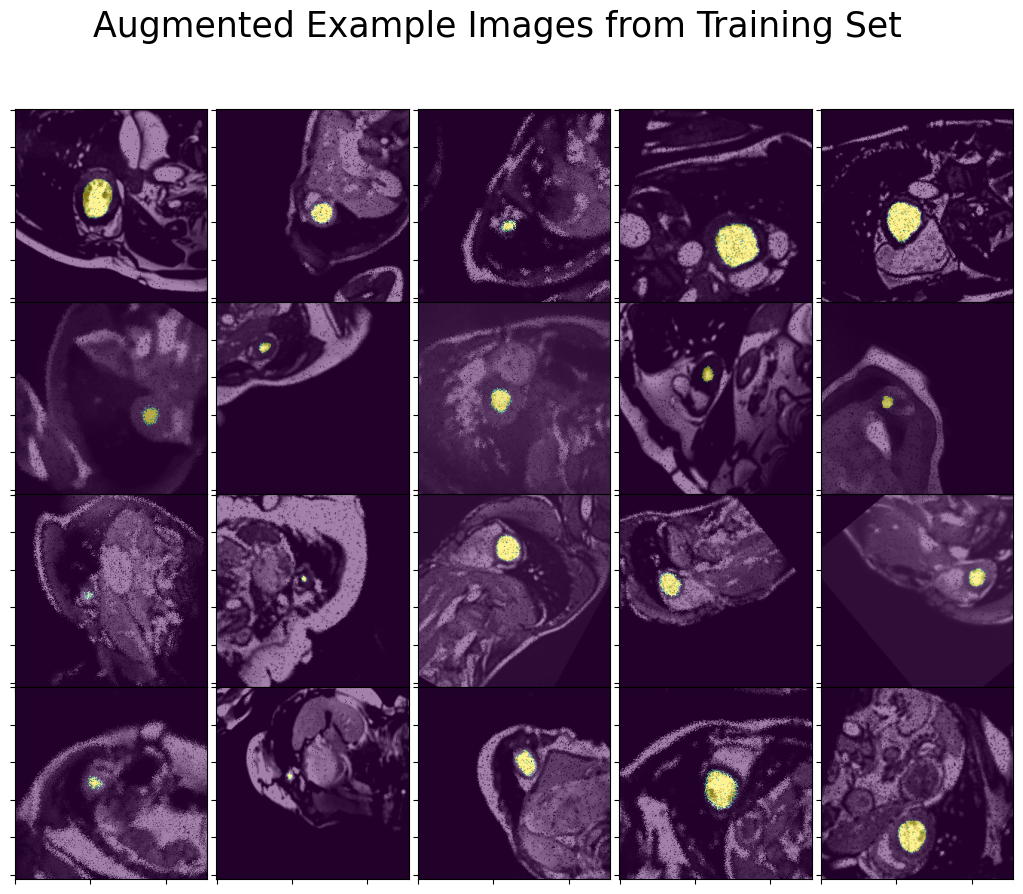

In [10]:
figs, axs = plt.subplots(4,5, figsize=(13, 10))
figs.subplots_adjust(wspace=0, hspace=0)
axs=axs.flatten()
counter = 0
for images, masks, pids in train_loader:
    if counter < 20:
        for j in range(len(images)):
            if counter < 20: # Plot 20 random images only
                img = np.array(images[j].permute(1, 2, 0))
                if img.max() - img.min() != 0:
                    img = (img - img.min()) / (img.max() - img.min())
                axs[counter].imshow(img, cmap=plt.get_cmap('gray'))
                msk = np.array(masks[j].permute(1, 2, 0))
                if msk.max() - msk.min() != 0:
                    msk = (msk - msk.min()) / (msk.max() - msk.min())
                axs[counter].imshow(msk, alpha=.5, )
                counter += 1
            else:
                break
    else:
        break
for ax in axs:
    ax.grid(False)
    ax.tick_params(labelbottom=False, labelleft=False)
plt.suptitle("Augmented Example Images from Training Set", fontsize=25)
plt.show()

# 4/5. Implementing and Training U-Net (2D)

In [11]:
def plot_example(image, mask, output, pid, display_bce=True): # Plotting function to visually compare the true mask to the predicted one
    image, mask, output = image.to("cpu"), mask.to("cpu"), output.to("cpu")
    figs, axs = plt.subplots(1,2, figsize=(8, 4))
    axs = axs.flatten()
    figs.suptitle(f"PID: {pid}")
    # Plot images 
    for k in range(2):
        img = np.array(image.permute(1, 2, 0))
        if img.max() - img.min() != 0:
            img = (img - img.min()) / (img.max() - img.min())
        axs[k].imshow(img, cmap=plt.get_cmap('gray'))
    
    # Plot true mask 
    msk = np.array(mask.permute(1, 2, 0))
    if msk.max() - msk.min() != 0:
        msk = (msk - msk.min()) / (msk.max() - msk.min())
    axs[0].imshow(msk, alpha=.5, )
    axs[0].set_title("True")
    
    # Plot predicted mask 
    pred = np.array(output.permute(1, 2, 0))
    if pred.max() - pred.min() != 0:
        pred = (pred - pred.min()) / (pred.max() - pred.min())
    axs[1].imshow(pred, alpha=.5, )
    if display_bce:
        axs[1].set_title(f"Predicted (BCELoss {get_loss(output, mask):.4f})")
    else:
        axs[1].set_title(f"Predicted")
    
    for ax in axs:
        ax.grid(False)
        ax.tick_params(labelbottom=False, labelleft=False)
    plt.show()

In [12]:
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 64, 3)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.conv2 = torch.nn.Conv2d(64, 64, 3)
        self.bn2 = torch.nn.BatchNorm2d(64)
        
        self.conv3 = torch.nn.Conv2d(64, 128, 3)
        self.bn3 = torch.nn.BatchNorm2d(128)
        self.conv4 = torch.nn.Conv2d(128, 128, 3)
        self.bn4 = torch.nn.BatchNorm2d(128)
        
        self.conv5 = torch.nn.Conv2d(128, 256, 3)
        self.bn5 = torch.nn.BatchNorm2d(256)
        self.conv6 = torch.nn.Conv2d(256, 256, 3)
        self.bn6 = torch.nn.BatchNorm2d(256)
        
        self.conv7 = torch.nn.Conv2d(256, 512, 3)
        self.bn7 = torch.nn.BatchNorm2d(512)
        self.conv8 = torch.nn.Conv2d(512, 512, 3)
        self.bn8 = torch.nn.BatchNorm2d(512)
        
        self.conv9 = torch.nn.Conv2d(512, 1024, 3)
        self.bn9 = torch.nn.BatchNorm2d(1024)
        self.conv10 = torch.nn.Conv2d(1024, 1024, 3)
        self.bn10 = torch.nn.BatchNorm2d(1024)
        
        self.upconv1 = torch.nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv_dc1 = torch.nn.Conv2d(1024, 512, 3)
        self.bn_dc1 = torch.nn.BatchNorm2d(512)
        self.conv_dc2 = torch.nn.Conv2d(512, 512, 3)
        self.bn_dc2 = torch.nn.BatchNorm2d(512)
        
        self.upconv2 = torch.nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv_dc3 = torch.nn.Conv2d(512, 256, 3)
        self.bn_dc3 = torch.nn.BatchNorm2d(256)
        self.conv_dc4 = torch.nn.Conv2d(256, 256, 3)
        self.bn_dc4 = torch.nn.BatchNorm2d(256)
        
        self.upconv3 = torch.nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv_dc5 = torch.nn.Conv2d(256, 128, 3)
        self.bn_dc5 = torch.nn.BatchNorm2d(128)
        self.conv_dc6 = torch.nn.Conv2d(128, 128, 3)
        self.bn_dc6 = torch.nn.BatchNorm2d(128)
        
        self.upconv4 = torch.nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv_dc7 = torch.nn.Conv2d(128, 64, 3)
        self.bn_dc7 = torch.nn.BatchNorm2d(64)
        self.conv_dc8 = torch.nn.Conv2d(64, 64, 3)
        self.bn_dc8 = torch.nn.BatchNorm2d(64)
        
        self.final_conv = torch.nn.Conv2d(64, 1, 1)
        

    def forward(self, x):
        encoder1 = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))
        encoder2 = F.max_pool2d(F.relu(self.bn4(self.conv4(F.relu(self.bn3(self.conv3(encoder1)))))), (2,2), stride=2)
        encoder3 = F.max_pool2d(F.relu(self.bn6(self.conv6(F.relu(self.bn5(self.conv5(encoder2)))))), (2,2), stride=2)
        encoder4 = F.max_pool2d(F.relu(self.bn8(self.conv8(F.relu(self.bn7(self.conv7(encoder3)))))), (2,2), stride=2)
        # 4 encoder/decoder steps seem to be optimal. The initial paper used 5 but their images where twice the size. The one maxpooling layer less outweighs that.
        #encoder5 = F.max_pool2d(F.relu(self.bn10(self.conv10(F.relu(self.bn9(self.conv9(encoder4)))))), (2,2), stride=2)
        
        #upconv = self.upconv1(encoder5)
        #decoder1 = F.relu(self.bn_dc2(self.conv_dc2(F.relu(self.bn_dc1(self.conv_dc1(torch.cat([transforms.CenterCrop(upconv.size()[2:])(encoder4), upconv], dim=1)))))))
        
        upconv = self.upconv2(encoder4)
        decoder2 = F.relu(self.bn_dc4(self.conv_dc4(F.relu(self.bn_dc3(self.conv_dc3(torch.cat([transforms.CenterCrop(upconv.size()[2:])(encoder3), upconv], dim=1)))))))
        
        upconv = self.upconv3(decoder2)
        decoder3 = F.relu(self.bn_dc6(self.conv_dc6(F.relu(self.bn_dc5(self.conv_dc5(torch.cat([transforms.CenterCrop(upconv.size()[2:])(encoder2), upconv], dim=1)))))))
        
        upconv = self.upconv4(decoder3)
        decoder4 = F.relu(self.bn_dc8(self.conv_dc8(F.relu(self.bn_dc7(self.conv_dc7(torch.cat([transforms.CenterCrop(upconv.size()[2:])(encoder1), upconv], dim=1)))))))
        
        return F.sigmoid(F.interpolate(self.final_conv(decoder4), size=x.size()[2:], mode="nearest"))


Epoch 1/20, Training:   0%|          | 0/107 [00:00<?, ?it/s]/home/hd/hd_hd/hd_uh325/.conda/envs/adlvmba/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.59it/s, val_DICE=0.0307, val_loss=0.0943]


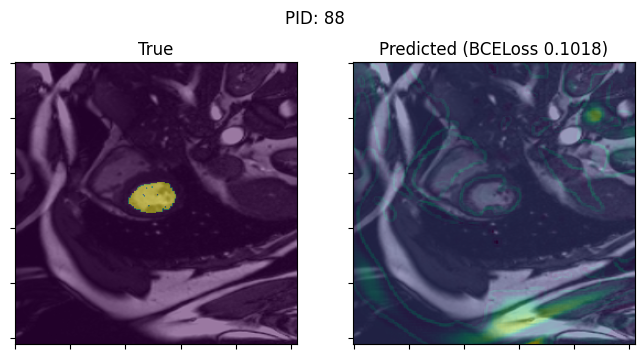

Epoch 2/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.55it/s, val_DICE=0.0426, val_loss=0.0625]


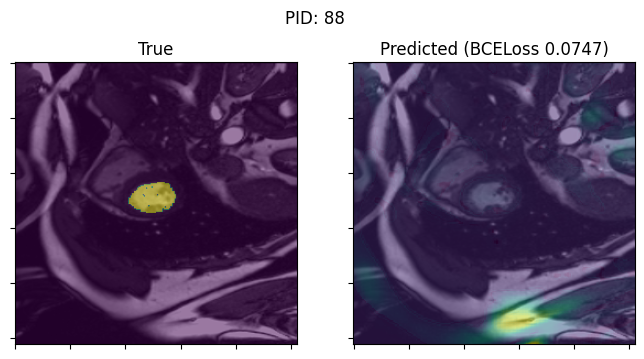

Epoch 3/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.62it/s, val_DICE=0.0543, val_loss=0.0522]


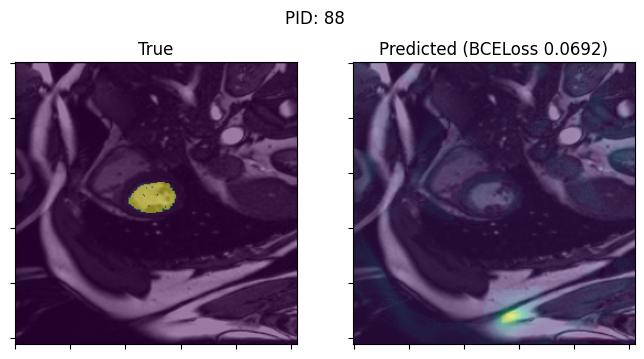

Epoch 4/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.38it/s, val_DICE=0.0527, val_loss=0.0485]


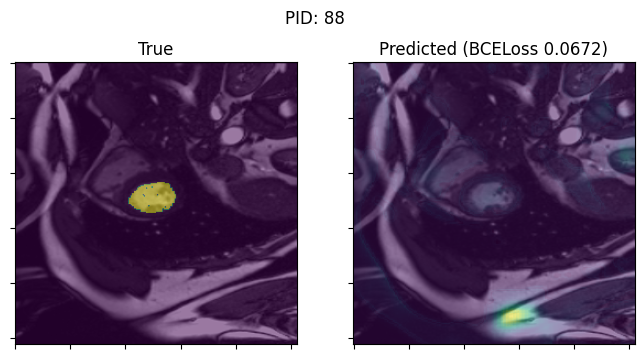

Epoch 5/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.54it/s, val_DICE=0.0511, val_loss=0.049] 


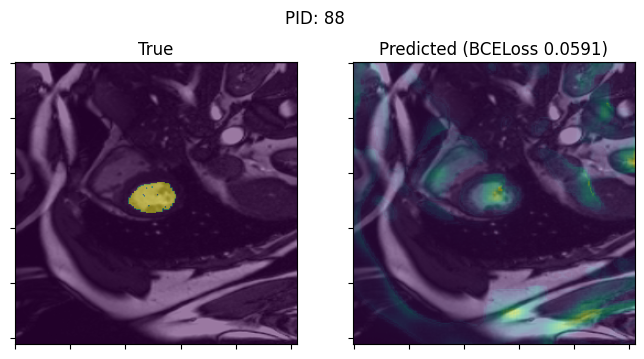

Epoch 6/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.31it/s, val_DICE=0.104, val_loss=0.0462] 


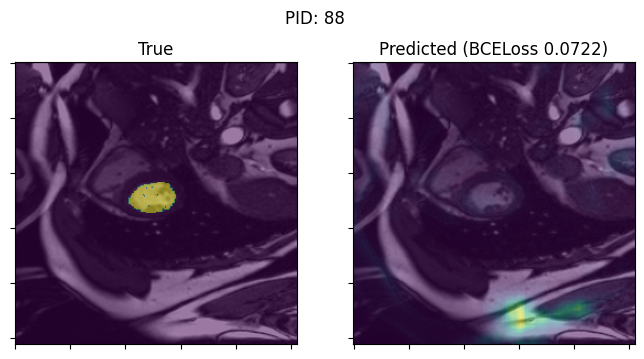

Epoch 7/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.60it/s, val_DICE=0.144, val_loss=0.042] 


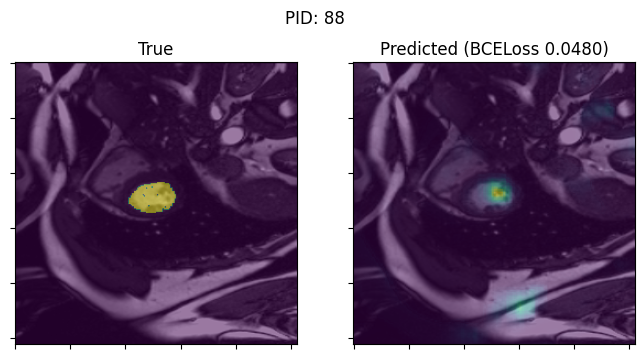

Epoch 8/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.52it/s, val_DICE=0.178, val_loss=0.0382]


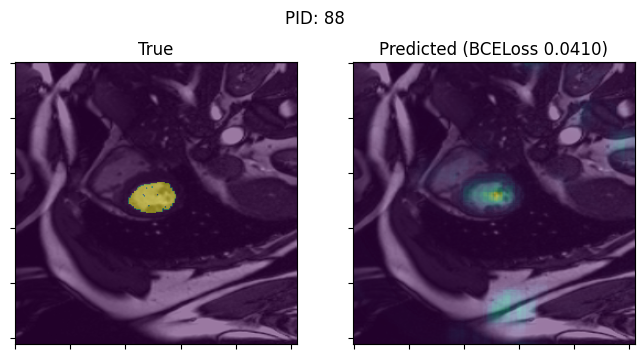

Epoch 9/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s, val_DICE=0.143, val_loss=0.0388]


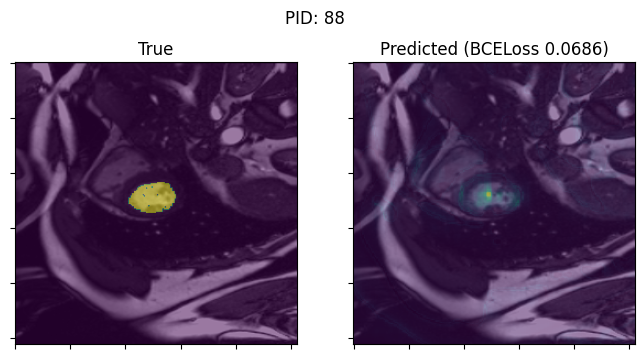

Epoch 10/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.28it/s, val_DICE=0.246, val_loss=0.0315]


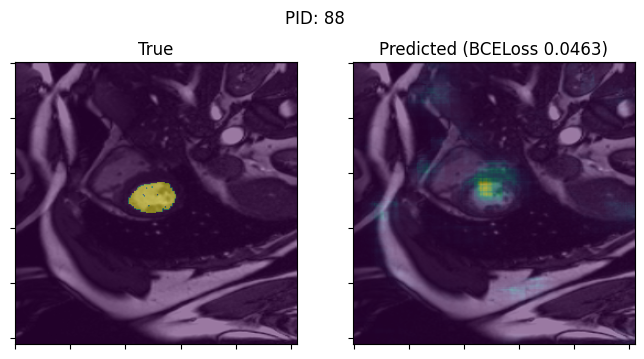

Epoch 11/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.70it/s, val_DICE=0.305, val_loss=0.0271]


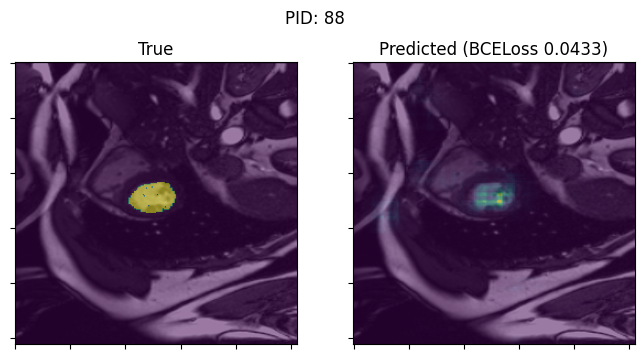

Epoch 12/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.37it/s, val_DICE=0.315, val_loss=0.0245]


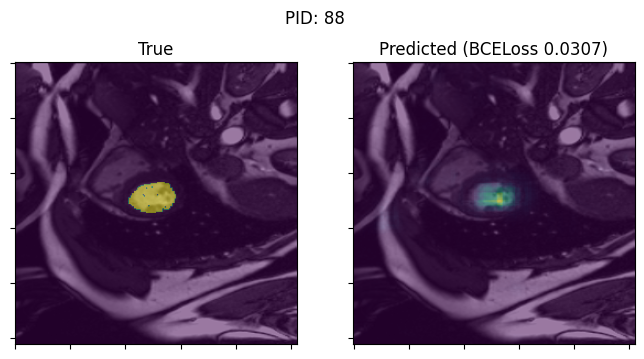

Epoch 13/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.42it/s, val_DICE=0.38, val_loss=0.0229] 


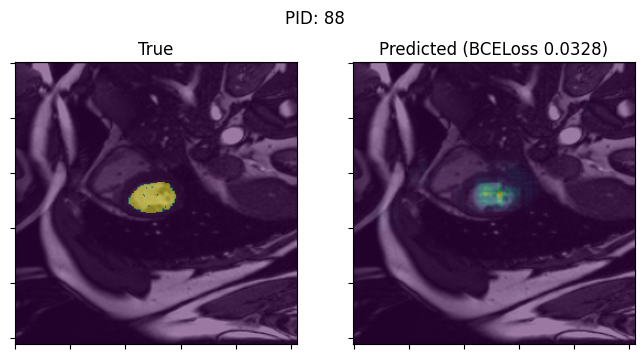

Epoch 14/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.44it/s, val_DICE=0.36, val_loss=0.0215] 


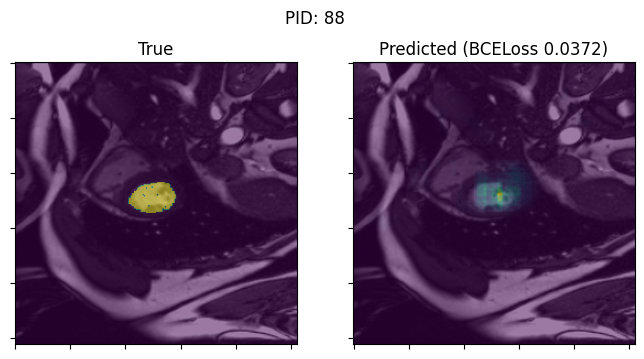

Epoch 15/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s, val_DICE=0.386, val_loss=0.021] 


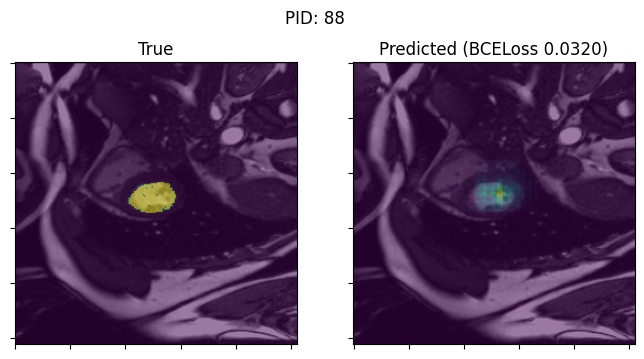

Epoch 16/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.54it/s, val_DICE=0.288, val_loss=0.0255]


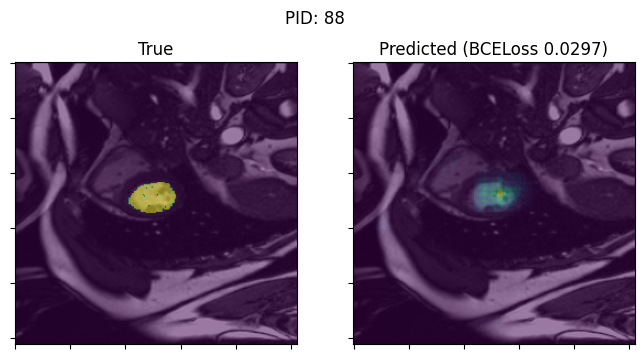

Epoch 17/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.24it/s, val_DICE=0.408, val_loss=0.0198]


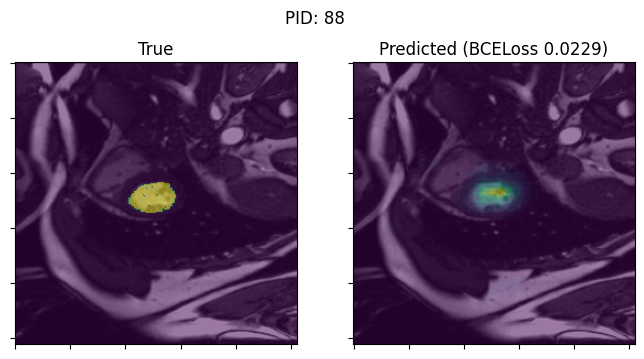

Epoch 18/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.10it/s, val_DICE=0.435, val_loss=0.0202]


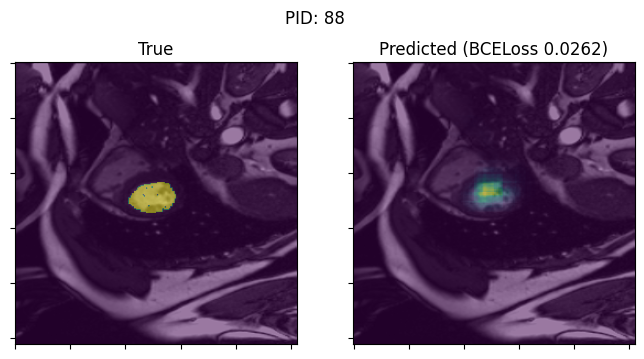

Epoch 19/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.48it/s, val_DICE=0.469, val_loss=0.0176]


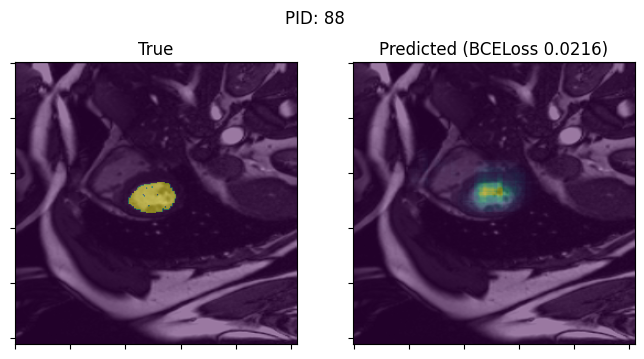

Epoch 20/20, Validation: 100%|██████████| 13/13 [00:02<00:00,  5.74it/s, val_DICE=0.465, val_loss=0.0175]


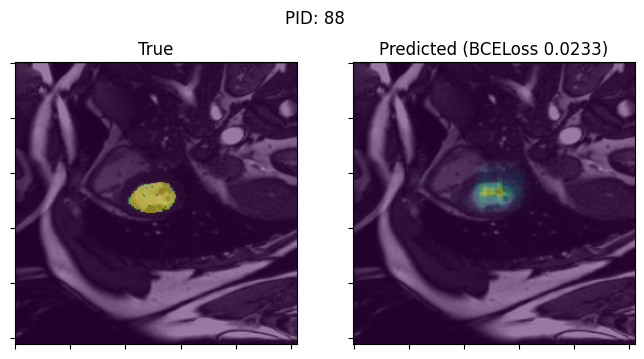

CPU times: user 9min 54s, sys: 13.6 s, total: 10min 8s
Wall time: 11min


In [13]:
%%time
model = UNet().to("cuda") # Create model and push it to the GPU

# Define loss function and optimizer
get_loss = nn.BCELoss() # Use Binary Crossentropy as loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=18, gamma=0.1)

def dice_coefficient(outputs, masks):
    intersection = torch.sum(outputs * masks)
    union = torch.sum(outputs) + torch.sum(masks)
    if union == 0:
        return 1.0
    dice = (2. * intersection) / union
    return dice.item()

curr_patience = 0
train_losses = []
val_losses = []
train_DICEs = []
val_DICEs = []
learning_rates = []
if train: # Only train if this var is true. Otherwise, the previous best model is loaded.
    # Training loop
    for epoch in range(max_num_epochs):
        model.train() # Set model to training state. So layers like dropout are active.
        train_loss = 0.0
        val_loss = 0.0
        train_DICE = 0.0
        val_DICE = 0.0
        # Training
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{max_num_epochs}, Training')
        
        for i, (images, masks, pids) in enumerate(progress_bar): # Iterate over batches
            images, masks = images.to("cuda"), masks.to("cuda") # Pus data to GPU
            optimizer.zero_grad() # Resetting gradients
            outputs = model(images) # Forward pass
            loss = get_loss(outputs, masks) # Calculate loss
            loss.backward() # Backpropagation
            optimizer.step() # Make one step towards the optimal direction
    
            train_loss += loss.item() * images.size(0)
            train_DICE += dice_coefficient(outputs, masks) * images.size(0)
            progress_bar.set_postfix(LR=scheduler.get_last_lr()[0], train_loss=train_loss / ((i * batch_size) + images.size(0)), train_DICE=train_DICE / ((i * batch_size) + images.size(0)))
    
        # Validation
        model.eval()  # Set model to validation state. So layers like dropout are inactive.
        with torch.no_grad(): # Do not compute gradients in the layers to increase speed as these are not needed for validation.
            progress_bar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{max_num_epochs}, Validation')
            for i, (images, masks, pids) in enumerate(progress_bar):
                images, masks = images.to("cuda"), masks.to("cuda")
                outputs = model(images) # Forward pass
                loss = get_loss(outputs, masks) # Only compute Loss. Nothing else.
    
                val_loss += loss.item() * images.size(0)
                val_DICE += dice_coefficient(outputs, masks) * images.size(0)
                progress_bar.set_postfix(val_loss=val_loss / ((i * batch_size) + images.size(0)), val_DICE=val_DICE / ((i * batch_size) + images.size(0)))
                    
            plot_example(images[10], masks[10], outputs[10], pids[10]) # Plot one example image per epoch
        
        
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        train_DICE /= len(train_loader.dataset)
        val_DICE /= len(val_loader.dataset)
        
        
        learning_rates.append(scheduler.get_last_lr()[0])
        scheduler.step() # Change the learning rate
        
        if np.any(val_loss >= np.array(val_losses)): # Early stopping. Save model with best validation.
            curr_patience += 1
        else:
            curr_patience = 0
            torch.save(model, "best_model.pth")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_DICEs.append(train_DICE)
        val_DICEs.append(val_DICE)
        
        if curr_patience == early_stopping_patience:
            break
model = torch.load("best_model.pth") # Load model with best validation

#### Plotting Training History

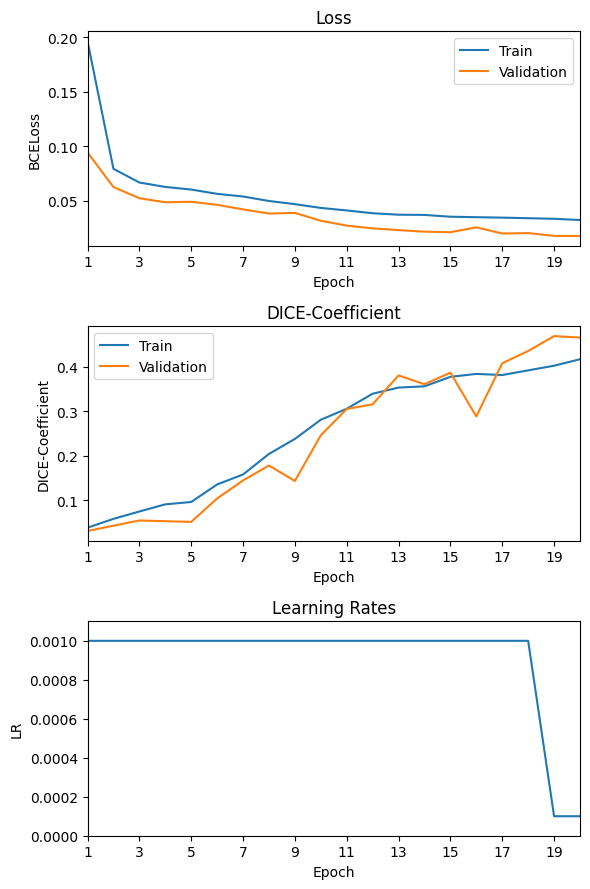

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(6, 9))
axs[0].set_title("Loss")
history = [train_losses, val_losses]
 
for i, set_type in enumerate(["Train", "Validation"]):
    axs[0].plot(range(1,len(history[i])+1),history[i], label=f"{set_type}")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("BCELoss")
axs[0].legend()
axs[0].set_xlim(1,len(history[0]))
axs[0].set_xticks(range(1,len(history[0]),2))
axs[1].set_title("DICE-Coefficient")
history_DICE = [train_DICEs, val_DICEs]
for i, set_type in enumerate(["Train","Validation"]):
    axs[1].plot(range(1,len(history[i])+1),history_DICE[i], label=f"{set_type}")
axs[1].set_xlabel("Epoch")
axs[1].set_xlim(1,len(history[0]))
axs[1].set_xticks(range(1,len(history[0]),2))
axs[1].set_ylabel("DICE-Coefficient")
axs[1].legend()
    
axs[2].set_title("Learning Rates")
axs[2].plot(range(1,len(history[i])+1),learning_rates)
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("LR")
axs[2].set_xlim(1,len(history[0]))
axs[2].set_xticks(range(1,len(history[0]),2))
axs[2].set_ylim(0.00000, 0.0011)

plt.tight_layout()
plt.show()

# 6. Downloading Test-Set

In [15]:
# Handle test data
# Data from https://humanheart-project.creatis.insa-lyon.fr/database/#collection/637218c173e9f0047faa00fb/folder/637218e573e9f0047faa00fc
# Put the unzipped "testing" folder into the project directory
# Following Code Ensures this file structure:
"""
project
│   Jannik_Mettner_218640.ipynb
└───testing
    └───patient101
    │    │   patient101_frame01.nii
    │    │   patient101_frame01_gt.nii
    │    │   patient101_frame14.nii
    │    │   patient101_frame14_gt.nii
    │   
    ...
"""
if os.path.exists(f"testing/MANDATORY_CITATION.md"):
    def unzip(zipped_file):
        with gzip.open(zipped_file, 'rb') as f_in:
            with open(zipped_file.replace(".gz",""), 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        # Delete the original .gz file
        os.remove(zipped_file)
    os.remove(f"testing/MANDATORY_CITATION.md")
    for patient in os.listdir("testing"):
        os.remove(f"testing/{patient}/Info.cfg")
        os.remove(f"testing/{patient}/MANDATORY_CITATION.md")
        os.remove(f"testing/{patient}/{patient}_4d.nii.gz")
    for patient in os.listdir("testing"):
        for file in os.listdir(f"testing/{patient}"):
            unzip(f"testing/{patient}/{file}")

In [16]:
#Open data and save in batches. The CustomDataset from before cannot be used as the data is in completely different format
imgs_test = []
masks_test = []
pids_test = []
for patient in os.listdir("testing"):
    for file in os.listdir(f"testing/{patient}"):
        if "gt" in file:
            mask = nib.load(f"testing/{patient}/{file}").get_fdata().astype("float32")
            mask[(mask==1) | (mask==2)] = 0
            mask[mask==3] = 1
            for i in range(mask.shape[2]):
                #masks_test.append(transform_mask_test(mask[:,:,i:i+1]))
                mask_tmp = np.expand_dims(resize(mask[:,:,i:i+1],(300,300)).astype(np.uint8), 0)
                masks_test.append(np.squeeze(seq_eval(images=mask_tmp.astype("float32"), segmentation_maps=mask_tmp)[1],3).astype("float32"))
        else:
            img = nib.load(f"testing/{patient}/{file}").get_fdata().astype("float32")
            for i in range(img.shape[2]):
                #imgs_test.append(transform_test(img[:,:,i:i+1]))
                
                img_tmp = resize(img[:,:,i:i+1], (300,300))
                img_tmp = ((img_tmp - img_tmp.min()) / (img_tmp.max() - img_tmp.min())) * 255
                img_tmp = np.squeeze(seq_eval(images=np.expand_dims(img_tmp,0)),3)
                
                imgs_test.append((img_tmp - img_tmp.min()) / (img_tmp.max() - img_tmp.min()))
                pids_test.append(patient)
imgs_test = torch.from_numpy(np.stack(imgs_test))
masks_test = torch.from_numpy(np.stack(masks_test))
# Calculate the number of batches and the size of the last batch
num_batches = len(imgs_test) // batch_size
last_batch_size = len(imgs_test) % batch_size

# Create batches
batches_img = []
batches_msk= []
batches_pid= []
for i in range(num_batches):
    batch_img = imgs_test[i * batch_size: (i + 1) * batch_size]
    batch_msk = masks_test[i * batch_size: (i + 1) * batch_size]
    batch_pid = pids_test[i * batch_size: (i + 1) * batch_size]
    batches_img.append(batch_img)
    batches_msk.append(batch_msk)
    batches_pid.append(batch_pid)

# Add the last batch if it's not empty
if last_batch_size > 0:
    last_batch_img = imgs_test[num_batches * batch_size:]
    last_batch_msk = masks_test[num_batches * batch_size:]
    last_batch_pid = pids_test[num_batches * batch_size:]
    batches_img.append(last_batch_img)
    batches_msk.append(last_batch_msk)
    batches_pid.append(last_batch_pid)

# 7. First Test Run
Get a first impression of what predicted masks look like on 10 example images. 

0it [00:00, ?it/s]

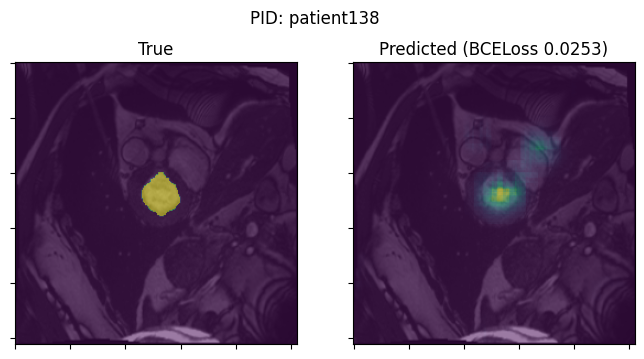

1it [00:00,  4.09it/s]

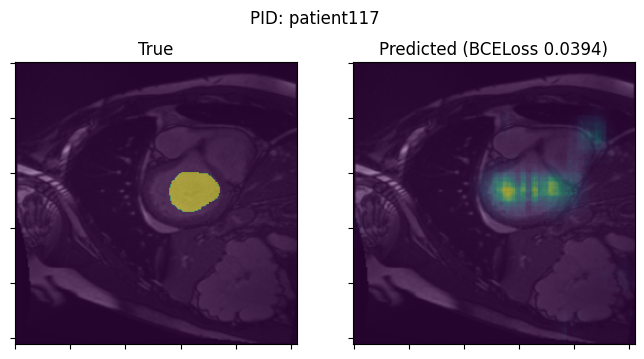

2it [00:00,  4.14it/s]

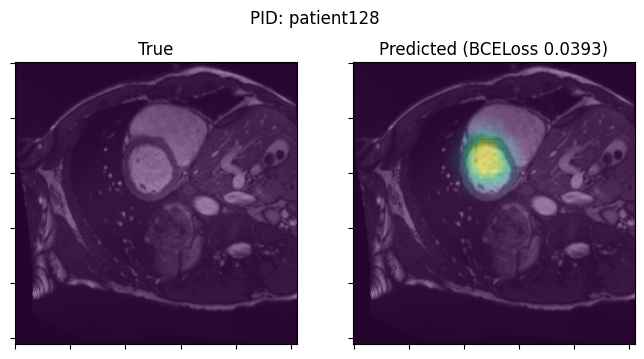

3it [00:00,  4.17it/s]

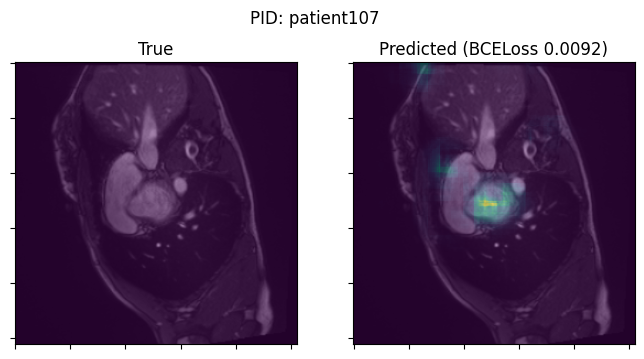

4it [00:00,  4.19it/s]

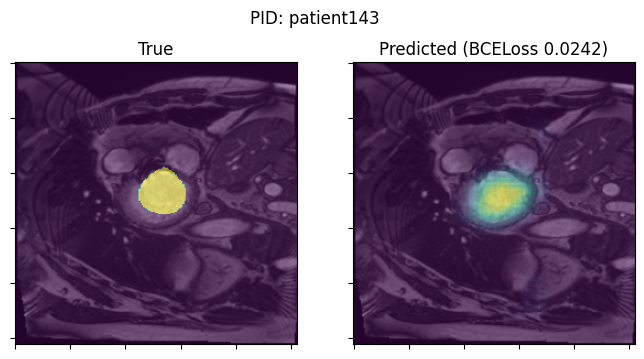

5it [00:01,  4.16it/s]

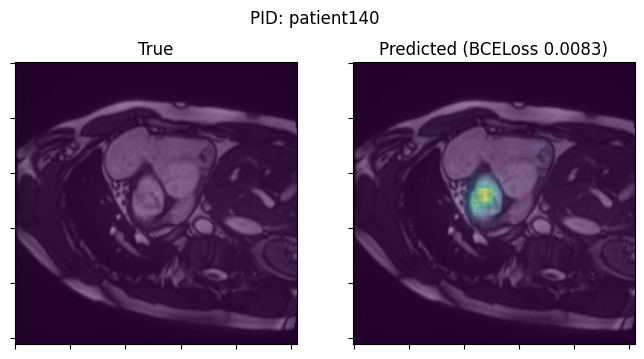

6it [00:01,  4.19it/s]

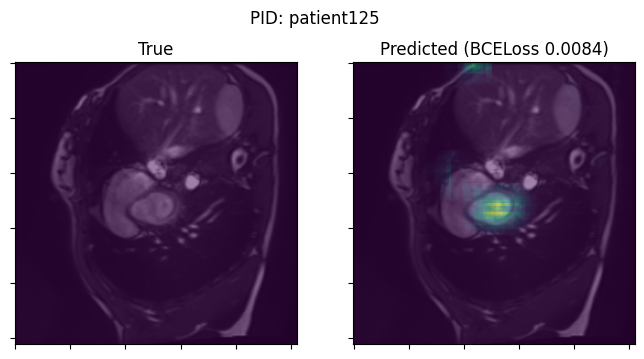

9it [00:01,  5.70it/s]

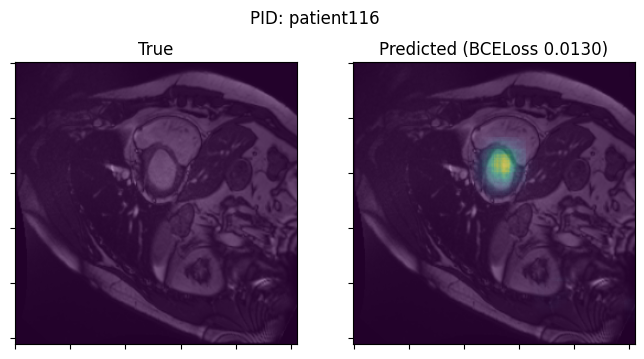

11it [00:02,  4.94it/s]

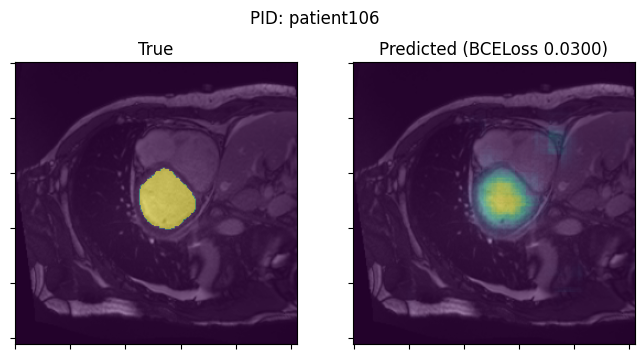

12it [00:02,  4.75it/s]

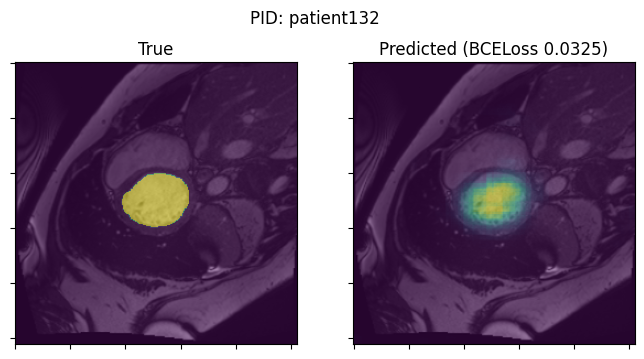

68it [00:07,  9.36it/s]


In [17]:
# Validation
model.eval()
displayed_patients = []
with torch.no_grad():
    progress_bar = tqdm(zip(batches_img, batches_msk, batches_pid))
    for i, data in enumerate(progress_bar):
        images, masks, pids = data
        images, masks = images.to("cuda"), masks.to("cuda")
        outputs = model(images)
        loss = get_loss(outputs, masks)
        
        for j, pid in enumerate(pids):
            if pid not in displayed_patients and len(displayed_patients) < 10:
                displayed_patients.append(pid)
                plot_example(images[j], masks[j], outputs[j], pid)

# 8. Evaluate with metrics
The segmentation metrics used are the DICE-Coefficient, the Hausdorff-Distance and the Jaccard-Coefficient.
Since the Hausdorff-Distance and the Jaccard-Coefficient require that the predicted mask is binary the images will get binarized after inference.
The optimal threshold for binarizing the predicted mask will now be determined.
Additionally, the Hausdorff-Distance works better in this case when there is only one connected component detected. This is because each image contains only one left ventricle.
To achieve that, the largest connected component will be selected.

Another thing to watch out for is that some given mask images from the dataset do not contain a mask and all pixel values are 0. The same thing can happen when all pixels in the predicted mask are below the binarized threshold. If either mask contains only 0-values, the Hausdorff-Distance and the Jaccard-Coefficient compute infinite values. Therefore, only when both contain nonzero pixels, the metrics will be computed.
Since this artificially increases the metrics, as cases where the model was not confident enough do not count, a confusion matrix will be provided. On the x-axis of the matrix is whether a mask exists and on the y-axis, whether the model detected and segmented anything. Finally, the matrix is used to derive the F1-score.

In [18]:
# Extract only the largest connected component because Hausdorff distance is to high when random pixels at the other side of the image are segmented by the nn. Also increases other metrics
def getLargestConnectedComponent(segmentation): 
    labels = label(segmentation)
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC.astype(int)

def dice_coefficient(outputs, masks):
    intersection = np.sum(outputs * masks)
    union = np.sum(outputs) + np.sum(masks)
    if union == 0:
        return 1.0
    dice = (2. * intersection) / union
    return dice.item()

dice_means = []
dice_stds = []
jaccard_means = []
jaccard_stds = []
hausdorff_means = []
hausdorff_stds = []
f1_scores = []

# Validation
model.eval()
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
with torch.no_grad():
    for opt_threshold in thresholds: # Iterate over possible thresholds
        tp, fp, tn, fn = 0, 0, 0, 0 # confusion matrix
        val_loss = 0.0
        displayed_patients = []
        dice_scores = []
        hausdorff_scores = []
        jaccard_scores = []
        progress_bar = tqdm(val_loader, desc=f'Test')
        for i, (images, masks, pids) in enumerate(progress_bar):
            images, masks = images.to("cuda"), masks.to("cuda")
            outputs = model(images)
            loss = get_loss(outputs, masks)
            val_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(val_loss=val_loss / ((i*batch_size)+1))
            
            # Binarize Image
            outputs[outputs>opt_threshold] = 1
            outputs[outputs<=opt_threshold] = 0
            
            for j in range(len(images)): # Compute Metrics
                mask = masks[j].to("cpu").numpy()[0]
                output = outputs[j].to("cpu").numpy()[0]
                if np.any(mask):
                    if np.any(output):
                        tp += 1
                        output = getLargestConnectedComponent(output)
                        dice_scores.append(dice_coefficient(output, mask))
                        jaccard_scores.append(jaccard_score(mask, output, average="micro"))
                        hausdorff_scores.append(hausdorff_distance(mask, output))
                    else:
                        fn += 1
                else:
                    if np.any(output):
                        fp += 1
                    else:
                        tn += 1
        
        val_loss /= len(val_loader.dataset)
        dice_means.append(sum(dice_scores) / len(dice_scores))
        dice_stds.append(torch.std(torch.tensor(dice_scores)))
        hausdorff_means.append(sum(hausdorff_scores) / len(hausdorff_scores))
        hausdorff_stds.append(torch.std(torch.tensor(hausdorff_scores)))
        jaccard_means.append(sum(jaccard_scores) / len(jaccard_scores))
        jaccard_stds.append(torch.std(torch.tensor(jaccard_scores)))
        f1_scores.append((2*tp) / (2*tp + fp + fn))
        
        print(f"THRESHOLD {opt_threshold}")
        print(f'Dice Coefficient: {dice_means[-1]:.4f} ± {dice_stds[-1]:.4f}')
        print(f'Jaccard Coefficient: {jaccard_means[-1]:.4f} ± {jaccard_stds[-1]:.4f}')
        print(f'Hausdorff Distance: {hausdorff_means[-1]:.4f} ± {hausdorff_stds[-1]:.4f}, Max: {max(hausdorff_scores):.4f}')
        print("Detection Confusion Matrix:")
        print(f"⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯")
        print(f"Detected  | True | {tp} | {fp}")
        print(f"          | False| {fn}  | {tn}")
        print(f"                 | True| False")
        print(f"                  Mask existing")
        print(f"Detection F1-score: {f1_scores[-1]}")
        print("--------------------------------------------------------------------------------------")


Test: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s, val_loss=0.0185]


THRESHOLD 0.1
Dice Coefficient: 0.5147 ± 0.1904
Jaccard Coefficient: 0.3666 ± 0.1600
Hausdorff Distance: 21.4663 ± 21.7306, Max: 175.5677
Detection Confusion Matrix:
⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Detected  | True | 182 | 9
          | False| 9  | 4
                 | True| False
                  Mask existing
Detection F1-score: 0.9528795811518325
--------------------------------------------------------------------------------------


Test: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s, val_loss=0.0185]


THRESHOLD 0.2
Dice Coefficient: 0.6309 ± 0.1971
Jaccard Coefficient: 0.4865 ± 0.1825
Hausdorff Distance: 14.4261 ± 11.5233, Max: 101.3903
Detection Confusion Matrix:
⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Detected  | True | 170 | 8
          | False| 21  | 5
                 | True| False
                  Mask existing
Detection F1-score: 0.9214092140921409
--------------------------------------------------------------------------------------


Test: 100%|██████████| 13/13 [00:03<00:00,  3.64it/s, val_loss=0.0185]


THRESHOLD 0.3
Dice Coefficient: 0.6681 ± 0.1974
Jaccard Coefficient: 0.5297 ± 0.1938
Hausdorff Distance: 11.4138 ± 8.0912, Max: 78.8923
Detection Confusion Matrix:
⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Detected  | True | 162 | 3
          | False| 29  | 10
                 | True| False
                  Mask existing
Detection F1-score: 0.9101123595505618
--------------------------------------------------------------------------------------


Test: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, val_loss=0.0185]


THRESHOLD 0.4
Dice Coefficient: 0.6469 ± 0.2230
Jaccard Coefficient: 0.5127 ± 0.2145
Hausdorff Distance: 10.7152 ± 6.0923, Max: 58.0517
Detection Confusion Matrix:
⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Detected  | True | 157 | 3
          | False| 34  | 10
                 | True| False
                  Mask existing
Detection F1-score: 0.8945868945868946
--------------------------------------------------------------------------------------


Test: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, val_loss=0.0185]


THRESHOLD 0.5
Dice Coefficient: 0.5937 ± 0.2440
Jaccard Coefficient: 0.4604 ± 0.2251
Hausdorff Distance: 11.6532 ± 5.9821, Max: 58.9406
Detection Confusion Matrix:
⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Detected  | True | 151 | 3
          | False| 40  | 10
                 | True| False
                  Mask existing
Detection F1-score: 0.8753623188405797
--------------------------------------------------------------------------------------


Test: 100%|██████████| 13/13 [00:03<00:00,  3.89it/s, val_loss=0.0185]


THRESHOLD 0.6
Dice Coefficient: 0.5206 ± 0.2453
Jaccard Coefficient: 0.3864 ± 0.2115
Hausdorff Distance: 13.7020 ± 6.9005, Max: 62.5859
Detection Confusion Matrix:
⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Detected  | True | 140 | 3
          | False| 51  | 10
                 | True| False
                  Mask existing
Detection F1-score: 0.8383233532934131
--------------------------------------------------------------------------------------


Test: 100%|██████████| 13/13 [00:03<00:00,  3.97it/s, val_loss=0.0185]


THRESHOLD 0.7
Dice Coefficient: 0.4425 ± 0.2123
Jaccard Coefficient: 0.3069 ± 0.1706
Hausdorff Distance: 15.3057 ± 6.6601, Max: 66.7608
Detection Confusion Matrix:
⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Detected  | True | 120 | 1
          | False| 71  | 12
                 | True| False
                  Mask existing
Detection F1-score: 0.7692307692307693
--------------------------------------------------------------------------------------


Test: 100%|██████████| 13/13 [00:03<00:00,  4.27it/s, val_loss=0.0185]


THRESHOLD 0.8
Dice Coefficient: 0.2854 ± 0.1832
Jaccard Coefficient: 0.1800 ± 0.1289
Hausdorff Distance: 17.8392 ± 4.6603, Max: 31.5753
Detection Confusion Matrix:
⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Detected  | True | 93 | 0
          | False| 98  | 13
                 | True| False
                  Mask existing
Detection F1-score: 0.6549295774647887
--------------------------------------------------------------------------------------


Test: 100%|██████████| 13/13 [00:02<00:00,  5.08it/s, val_loss=0.0185]

THRESHOLD 0.9
Dice Coefficient: 0.0627 ± 0.0788
Jaccard Coefficient: 0.0341 ± 0.0457
Hausdorff Distance: 24.4101 ± 8.8698, Max: 44.6430
Detection Confusion Matrix:
⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Detected  | True | 26 | 0
          | False| 165  | 13
                 | True| False
                  Mask existing
Detection F1-score: 0.23963133640552994
--------------------------------------------------------------------------------------


Now all metrics are plotted and from that the optimal threshold will be derived. For that the AUC will not be used, since it can only optimise the threshold for two metrics. Using this approach, we can compare 4 metrics

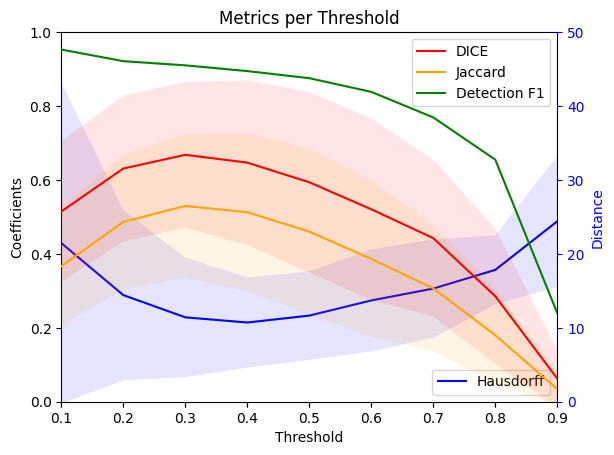

In [19]:
dice_means, jaccard_means, hausdorff_means = np.array(dice_means), np.array(jaccard_means), np.array(hausdorff_means)
dice_stds, jaccard_stds, hausdorff_stds = np.array(dice_stds), np.array(jaccard_stds), np.array(hausdorff_stds)

fig=plt.figure()
ax2=fig.add_subplot(111, label="1")
ax=fig.add_subplot(111, label="2", frame_on=False)
ax.plot(thresholds, dice_means, color="red", label="DICE")
ax.plot(thresholds, jaccard_means, color="orange", label="Jaccard")
ax.fill_between(thresholds, dice_means+dice_stds, dice_means-dice_stds, facecolor='red', alpha=0.1)
ax.fill_between(thresholds, jaccard_means+jaccard_stds, jaccard_means-jaccard_stds, facecolor='orange', alpha=0.1)
ax.plot(thresholds, f1_scores, color="green", label="Detection F1")
ax.tick_params(axis='y')
ax.set_ylabel("Coefficients")
ax.set_xlabel("Threshold")
ax.set_ylim(0,1)
ax.set_xlim(0.1,0.9)
ax.legend()
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right') 
ax2.plot(thresholds, hausdorff_means, color="blue", label="Hausdorff")
ax2.fill_between(thresholds, hausdorff_means+hausdorff_stds, hausdorff_means-hausdorff_stds, facecolor='blue', alpha=0.1)
ax2.tick_params(axis='y', colors="blue")
ax2.set_ylabel("Distance", color="blue")
ax2.set_xticklabels([])
ax2.set_ylim(0,50)
ax2.set_xlim(0.1,0.9)

ax2.legend(loc="lower right")
plt.title("Metrics per Threshold")
plt.show()

In [20]:
opt_threshold = 0.3 # Best trade-off over all metrics

In [21]:
# Validation
model.eval()
best_patient = {
    "DCM":[0],
    "HCM":[0],
    "MINF":[0],
    "NOR":[0],
    "RV":[0]
}
worst_patient = {
    "DCM":[1],
    "HCM":[1],
    "MINF":[1],
    "NOR":[1],
    "RV":[1]
}
def getGroup(pid):
    if pid <= 20:
        return "DCM"
    if pid <= 40:
        return "HCM"
    if pid <= 60:
        return "MINF"
    if pid <= 80:
        return "NOR"
    else:
        return "RV"
for set_type, loader in [("Train", train_loader), ("Validation", val_loader), ("Test", zip(batches_img, batches_msk, batches_pid))]:
    test_loss = 0.0
    tp, fp, tn, fn = 0, 0, 0, 0 # Confusion matrix
    tps, fns, fps, tns = [],[],[],[]
    displayed_patients = []
    dice_scores = []
    hausdorff_scores = []
    jaccard_scores = []
    with torch.no_grad():
        progress_bar = tqdm(loader, desc=f'{set_type}')
        for i, data in enumerate(progress_bar):
            images, masks, pids = data
            images, masks = images.to("cuda"), masks.to("cuda")
            outputs = model(images)
            loss = get_loss(outputs, masks)
    
            test_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(loss=test_loss / ((i*batch_size)+1))
            
            # Binarize Image
            outputs[outputs>opt_threshold] = 1
            outputs[outputs<=opt_threshold] = 0
            
            for j in range(len(images)): # Compute metrics
                mask = masks[j].to("cpu").numpy()[0]
                output = outputs[j].to("cpu").numpy()[0]
                image = images[j]
                pid = pids[j]
                if np.any(mask):
                    if np.any(output):
                        tp += 1
                        output = getLargestConnectedComponent(output)
                        dice_scores.append(dice_coefficient(output, mask))
                        jaccard_scores.append(jaccard_score(mask, output, average="micro"))
                        hausdorff_scores.append(hausdorff_distance(mask, output))
                        tps.append([image, mask, output, pid])
                        
                        if set_type == "Validation": # Record best and worst pathologies from validation set
                            group = getGroup(pid)
                            if best_patient[group][0] < dice_scores[-1]:
                                best_patient[group] = [dice_scores[-1], image, torch.from_numpy(np.expand_dims(mask,0)), torch.from_numpy(np.expand_dims(output,0)), pid]
                            if worst_patient[group][0] > dice_scores[-1]:
                                worst_patient[group] = [dice_scores[-1], image, torch.from_numpy(np.expand_dims(mask,0)), torch.from_numpy(np.expand_dims(output,0)), pid]
                    else:
                        fn += 1
                        fns.append([image, mask, output, pid])
                else:
                    if np.any(output):
                        fp += 1
                        output = getLargestConnectedComponent(output)
                        fps.append([image, mask, output, pid])
                    else:
                        tn += 1
                        tns.append([image, mask, output, pid])
                    
    if set_type == "Test":
        test_loss /= len(pids_test)
    else:
        test_loss /= len(loader.dataset)
    print(f'{set_type} Loss: {test_loss:.4f}')
    print(f'{set_type} Dice Coefficient: {sum(dice_scores) / len(dice_scores):.4f} ± {torch.std(torch.tensor(dice_scores)):.4f}')
    print(f'{set_type} Jaccard Coefficient: {sum(jaccard_scores) / len(jaccard_scores):.4f} ± {torch.std(torch.tensor(jaccard_scores)):.4f}')
    print(f'{set_type} Hausdorff Distance: {sum(hausdorff_scores) / len(hausdorff_scores):.4f} ± {torch.std(torch.tensor(hausdorff_scores)):.4f}, Max: {max(hausdorff_scores):.4f}')
    print("Detection Confusion Matrix:")
    print(f"⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯")
    print(f"Detected  | True | {tp} | {fp}")
    print(f"          | False| {fn}  | {tn}")
    print(f"                 | True| False")
    print(f"                  Mask existing")
    print(f"Detection F1-score: {(2*tp) / (2*tp + fp + fn)}")
    print("--------------------------------------------------------------------------------------")

Train: 100%|██████████| 107/107 [00:21<00:00,  4.93it/s, loss=0.0326]


Train Loss: 0.0325
Train Dice Coefficient: 0.5020 ± 0.2739
Train Jaccard Coefficient: 0.3780 ± 0.2377
Train Hausdorff Distance: 21.3793 ± 22.5070, Max: 224.9644
Detection Confusion Matrix:
⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Detected  | True | 1428 | 33
          | False| 188  | 49
                 | True| False
                  Mask existing
Detection F1-score: 0.9281767955801105
--------------------------------------------------------------------------------------


Validation: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s, loss=0.0185]


Validation Loss: 0.0175
Validation Dice Coefficient: 0.6681 ± 0.1974
Validation Jaccard Coefficient: 0.5297 ± 0.1938
Validation Hausdorff Distance: 11.4138 ± 8.0912, Max: 78.8923
Detection Confusion Matrix:
⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Detected  | True | 162 | 3
          | False| 29  | 10
                 | True| False
                  Mask existing
Detection F1-score: 0.9101123595505618
--------------------------------------------------------------------------------------


Test: 68it [00:11,  5.73it/s, loss=0.0217]

Test Loss: 0.0217
Test Dice Coefficient: 0.5706 ± 0.2640
Test Jaccard Coefficient: 0.4433 ± 0.2427
Test Hausdorff Distance: 15.4461 ± 16.7062, Max: 169.0710
Detection Confusion Matrix:
⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
Detected  | True | 845 | 50
          | False| 132  | 49
                 | True| False
                  Mask existing
Detection F1-score: 0.9027777777777778
--------------------------------------------------------------------------------------


# 9. Best and Worst segmentations
 according to the DICE-score.

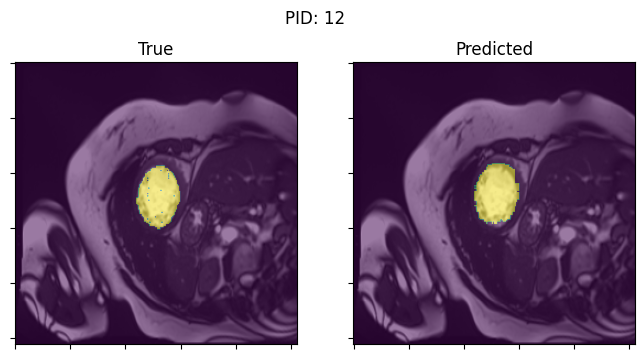

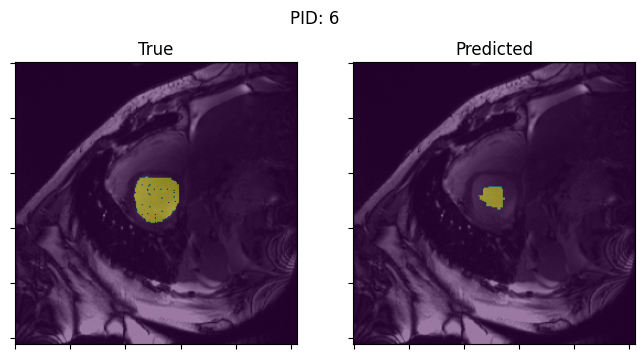

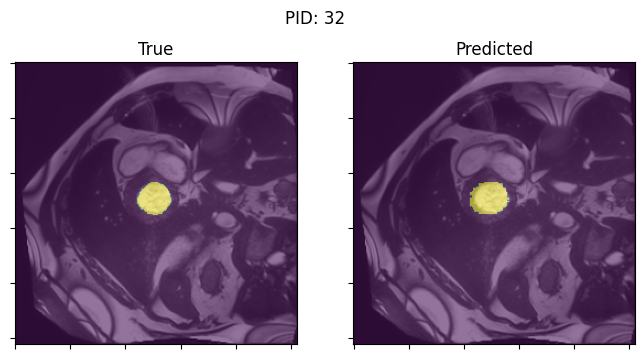

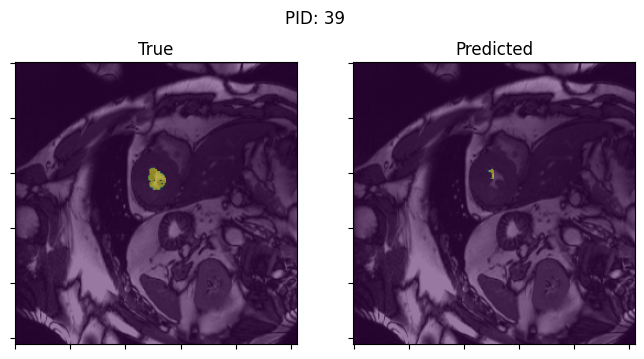

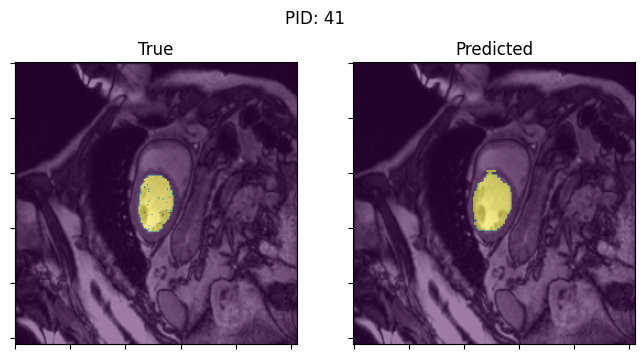

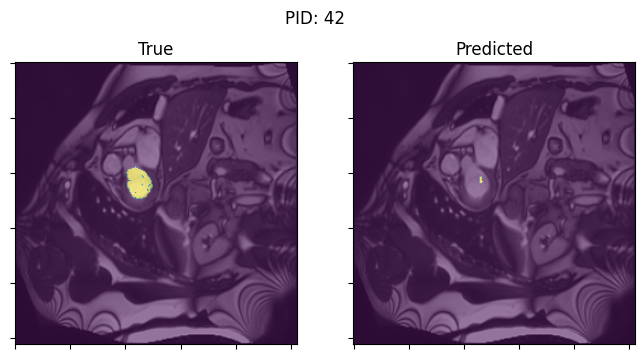

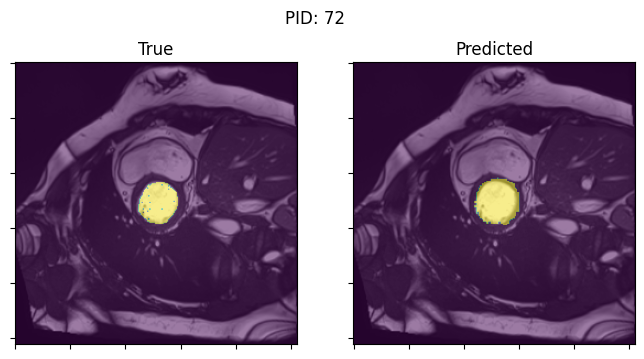

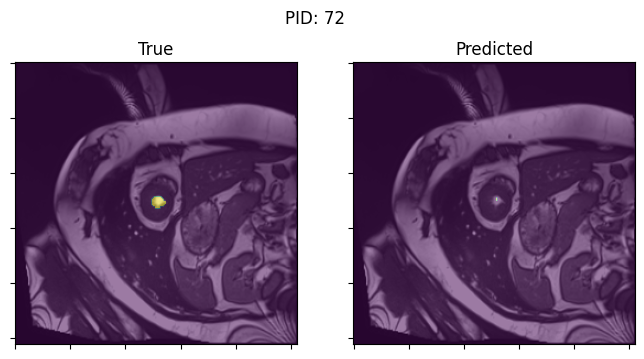

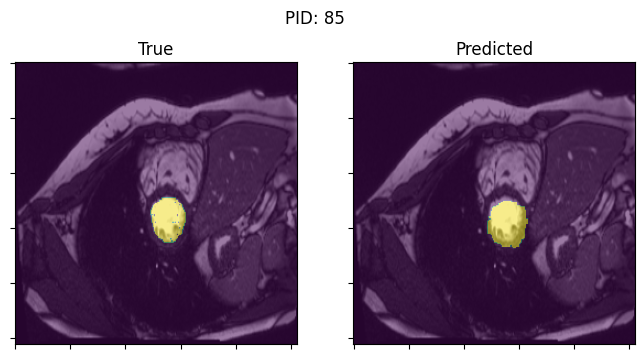

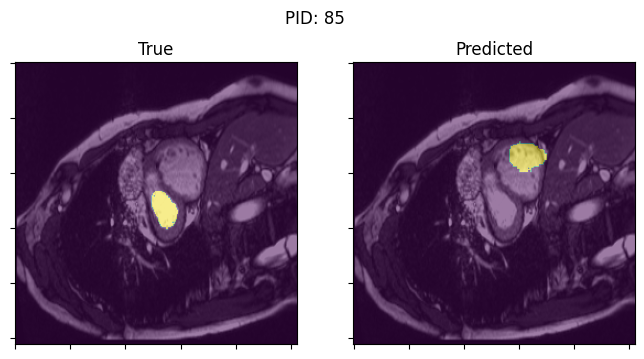

In [22]:
for group in ["DCM", "HCM", "MINF", "NOR", "RV"]:
    plot_example(*best_patient[group][1:], display_bce=False)
    plot_example(*worst_patient[group][1:], display_bce=False)